In [205]:
#Import all the necessary libraries
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import joblib
import os
import optuna
import random
from torch import optim
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import torch.nn as nn


In [206]:
#setting seed
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    # Ensure deterministic behavior
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

In [207]:

# Load preprocessed and scaled datasets (features and labels)
X_train, y_train = joblib.load(r"D:\Projects\DL_gtzan\data\preprocessed_data\train_data_scaled.pkl")
X_val, y_val     = joblib.load(r"D:\Projects\DL_gtzan\data\preprocessed_data\val_data_scaled.pkl")
X_test, y_test   = joblib.load(r"D:\Projects\DL_gtzan\data\preprocessed_data\test_data_scaled.pkl")

# Define a custom PyTorch Dataset class for genre classification
class GenreDataLoader(torch.utils.data.Dataset):
    def __init__(self, X, y):
        # Convert numpy arrays to PyTorch tensors
        self.X = torch.tensor(X, dtype=torch.float32)  # Input features
        self.y = torch.tensor(y, dtype=torch.long)     # Class labels (as required by CrossEntropyLoss)

    def __len__(self):
        # Returns the number of samples in the dataset
        return len(self.X)

    def __getitem__(self, idx):
        # Allows indexing to retrieve individual feature-label pairs
        return self.X[idx], self.y[idx]

# Wrap datasets in DataLoaders to handle batching, shuffling, and iteration
train_loader = DataLoader(GenreDataLoader(X_train, y_train), batch_size=128, shuffle=True)   # Shuffling improves generalization during training
val_loader   = DataLoader(GenreDataLoader(X_val, y_val), batch_size=128, shuffle=False)       # No shuffling for validation/testing
test_loader  = DataLoader(GenreDataLoader(X_test, y_test), batch_size=128, shuffle=False)


In [208]:
def evaluate(model, dataloader, device):
    """
    Evaluates model accuracy on the provided dataloader.
    """
    model.eval()  # Set model to evaluation mode
    correct = 0  # Initialize correct predictions count
    total = 0  # Initialize total samples count

    with torch.no_grad():  # Disable gradient computation
        for xb, yb in dataloader:
            xb, yb = xb.to(device), yb.to(device)  # Move data to device
            outputs = model(xb)  # Get model predictions
            preds = torch.argmax(outputs, dim=1)  # Get predicted classes
            correct += (preds == yb).sum().item()  # Count correct predictions
            total += yb.size(0)  # Count total samples

    accuracy = correct / total  # Calculate accuracy
    return accuracy  # Return accuracy


In [209]:
def objective(trial):

    # Suggest hyperparameters
    hidden_dim1 = trial.suggest_int("hidden_dim1", 128, 1024, step=128)
    hidden_dim2 = trial.suggest_int("hidden_dim2", 64, 512, step=64)
    dropout = trial.suggest_float("dropout", 0.1, 0.5)
    lr = trial.suggest_float("lr", 1e-4, 1e-2, log=True)
    batch_size = trial.suggest_categorical("batch_size", [64, 128, 256])

    # Create data loaders
    train_loader = DataLoader(GenreDataLoader(X_train, y_train), batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(GenreDataLoader(X_val, y_val), batch_size=batch_size)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = GenreNetMLP(
        input_dim=X_train.shape[1],
        hidden_dims=[hidden_dim1, hidden_dim2],
        dropout=dropout
    ).to(device)

    optimizer = optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.CrossEntropyLoss()

    # Train and validate
    for epoch in range(20):  # shorter epochs for tuning
        train_loop(model, train_loader, loss_fn, optimizer, device)
    val_acc = evaluates(model, val_loader, device)

    return val_acc


# Performing Hyperparameter Tuning

In [210]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30)
trial = study.best_trial  # Get the best trial from the study

print("Best trial:")
trial = study.best_trial
for key, value in trial.params.items():
    print(f"  {key}: {value}")
print(f"Best Validation Accuracy: {trial.value:.4f}")


[I 2025-05-05 04:42:39,269] A new study created in memory with name: no-name-f1e3646e-69e8-4df4-b17e-3b0f884abcd3
[I 2025-05-05 04:42:47,382] Trial 0 finished with value: 0.8544726301735648 and parameters: {'hidden_dim1': 1024, 'hidden_dim2': 448, 'dropout': 0.48153628119385417, 'lr': 0.00019122273267274667, 'batch_size': 64}. Best is trial 0 with value: 0.8544726301735648.
[I 2025-05-05 04:42:51,465] Trial 1 finished with value: 0.8805073431241656 and parameters: {'hidden_dim1': 768, 'hidden_dim2': 384, 'dropout': 0.49510015286941866, 'lr': 0.008836690661680014, 'batch_size': 128}. Best is trial 1 with value: 0.8805073431241656.
[I 2025-05-05 04:42:59,790] Trial 2 finished with value: 0.7757009345794392 and parameters: {'hidden_dim1': 640, 'hidden_dim2': 64, 'dropout': 0.45063994090042647, 'lr': 0.00015743978412710816, 'batch_size': 64}. Best is trial 1 with value: 0.8805073431241656.
[I 2025-05-05 04:43:07,105] Trial 3 finished with value: 0.7296395193591455 and parameters: {'hidden_

Best trial:
  hidden_dim1: 512
  hidden_dim2: 448
  dropout: 0.27717784738470697
  lr: 0.004930099911959386
  batch_size: 256
Best Validation Accuracy: 0.9152


###  Best MLP Model After Hyperparameter tuning


In [211]:
import torch
import torch.nn as nn

# Define a class for the MLP model that uses the best hyperparameters from Optuna
class OptunaBestMLP(nn.Module):
    # The constructor of the model accepts the input dimension, trial parameters, and number of classes
    def __init__(self, input_dim, trial_params, num_classes=10):
        super().__init__()  # Call the parent class constructor (nn.Module)
        
        # Extract the hyperparameters from the trial parameters passed during initialization
        hidden_dim1 = trial_params["hidden_dim1"]  # First hidden layer dimension
        hidden_dim2 = trial_params["hidden_dim2"]  # Second hidden layer dimension
        dropout = trial_params["dropout"]  # Dropout rate
        
        # Define the neural network architecture using nn.Sequential
        self.model = nn.Sequential(
            # First fully connected layer (input layer to hidden layer)
            nn.Linear(input_dim, hidden_dim1),
            nn.BatchNorm1d(hidden_dim1),  # Batch normalization for better training stability
            nn.ReLU(),  # ReLU activation function to introduce non-linearity
            nn.Dropout(dropout),  # Dropout layer to prevent overfitting

            # Second fully connected layer (hidden layer to second hidden layer)
            nn.Linear(hidden_dim1, hidden_dim2),
            nn.BatchNorm1d(hidden_dim2),  # Batch normalization again
            nn.ReLU(),  # ReLU activation for non-linearity
            nn.Dropout(dropout),  # Dropout layer for the second hidden layer

            # Output layer (final classification layer)
            nn.Linear(hidden_dim2, num_classes)  # Output layer for classification
        )

    # Define the forward pass for the model
    def forward(self, x):
        return self.model(x)  # Forward pass through the entire model


In [212]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
input_dim = X_train.shape[1]
best_trial_params = study.best_trial.params
model = OptunaBestMLP(input_dim, trial_params=best_trial_params).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0042241)  # Optuna best
loss_fn = nn.CrossEntropyLoss()

def train_loop(model, dataloader, loss_fn, optimizer, device):
    model.train()
    total_loss, total_correct = 0, 0
    for xb, yb in dataloader:
        xb, yb = xb.to(device), yb.to(device)
        pred = model(xb)
        loss = loss_fn(pred, yb)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * xb.size(0)
        total_correct += (pred.argmax(1) == yb).sum().item()

    return total_loss / len(dataloader.dataset), total_correct / len(dataloader.dataset)

def evaluate(model, dataloader, device):
    model.eval()
    total_correct = 0
    with torch.no_grad():
        for xb, yb in dataloader:
            xb, yb = xb.to(device), yb.to(device)
            pred = model(xb)
            total_correct += (pred.argmax(1) == yb).sum().item()
    return total_correct / len(dataloader.dataset)

# Training
epochs = 100
for epoch in range(epochs):
    train_loss, train_acc = train_loop(model, train_loader, loss_fn, optimizer, device)
    val_acc = evaluate(model, val_loader, device)
    print(f"Epoch {epoch+1}/{epochs} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['train_acc'].append(train_acc)
    history['val_acc'].append(val_acc)

Epoch 1/100 | Train Acc: 0.6325 | Val Acc: 0.7303
Epoch 2/100 | Train Acc: 0.7585 | Val Acc: 0.7677
Epoch 3/100 | Train Acc: 0.7954 | Val Acc: 0.8164
Epoch 4/100 | Train Acc: 0.8291 | Val Acc: 0.8278
Epoch 5/100 | Train Acc: 0.8450 | Val Acc: 0.8391
Epoch 6/100 | Train Acc: 0.8672 | Val Acc: 0.8511
Epoch 7/100 | Train Acc: 0.8806 | Val Acc: 0.8571
Epoch 8/100 | Train Acc: 0.8897 | Val Acc: 0.8812
Epoch 9/100 | Train Acc: 0.9045 | Val Acc: 0.8765
Epoch 10/100 | Train Acc: 0.9132 | Val Acc: 0.8732
Epoch 11/100 | Train Acc: 0.9151 | Val Acc: 0.8785
Epoch 12/100 | Train Acc: 0.9255 | Val Acc: 0.8805
Epoch 13/100 | Train Acc: 0.9312 | Val Acc: 0.8872
Epoch 14/100 | Train Acc: 0.9359 | Val Acc: 0.8985
Epoch 15/100 | Train Acc: 0.9395 | Val Acc: 0.8979
Epoch 16/100 | Train Acc: 0.9458 | Val Acc: 0.8945
Epoch 17/100 | Train Acc: 0.9468 | Val Acc: 0.8999
Epoch 18/100 | Train Acc: 0.9465 | Val Acc: 0.8932
Epoch 19/100 | Train Acc: 0.9512 | Val Acc: 0.9059
Epoch 20/100 | Train Acc: 0.9570 | Val A

In [213]:

def evaluate_model_results(model, dataloader, class_names, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for xb, yb in dataloader:
            xb = xb.to(device)
            logits = model(xb)
            preds = torch.argmax(logits, dim=1).cpu().numpy()
            labels = yb.numpy()

            all_preds.extend(preds)
            all_labels.extend(labels)

    # Metrics
    acc = accuracy_score(all_labels, all_preds)
    report = classification_report(all_labels, all_preds, target_names=class_names, digits=4)
    cm = confusion_matrix(all_labels, all_preds)

    print(f"\n🎯 Accuracy: {acc:.4f}")
    print("\n📋 Classification Report:")
    print(report)

    # Confusion Matrix Plot
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names, cmap="Blues")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()



🎯 Accuracy: 0.9233

📋 Classification Report:
              precision    recall  f1-score   support

       blues     0.9408    0.9533    0.9470       150
   classical     0.9346    0.9533    0.9439       150
     country     0.9556    0.8658    0.9085       149
       disco     0.9272    0.9333    0.9302       150
      hiphop     0.9589    0.9333    0.9459       150
        jazz     0.8688    0.9267    0.8968       150
       metal     0.9648    0.9133    0.9384       150
         pop     0.9156    0.9400    0.9276       150
      reggae     0.9595    0.9467    0.9530       150
        rock     0.8228    0.8667    0.8442       150

    accuracy                         0.9233      1499
   macro avg     0.9248    0.9232    0.9235      1499
weighted avg     0.9248    0.9233    0.9236      1499



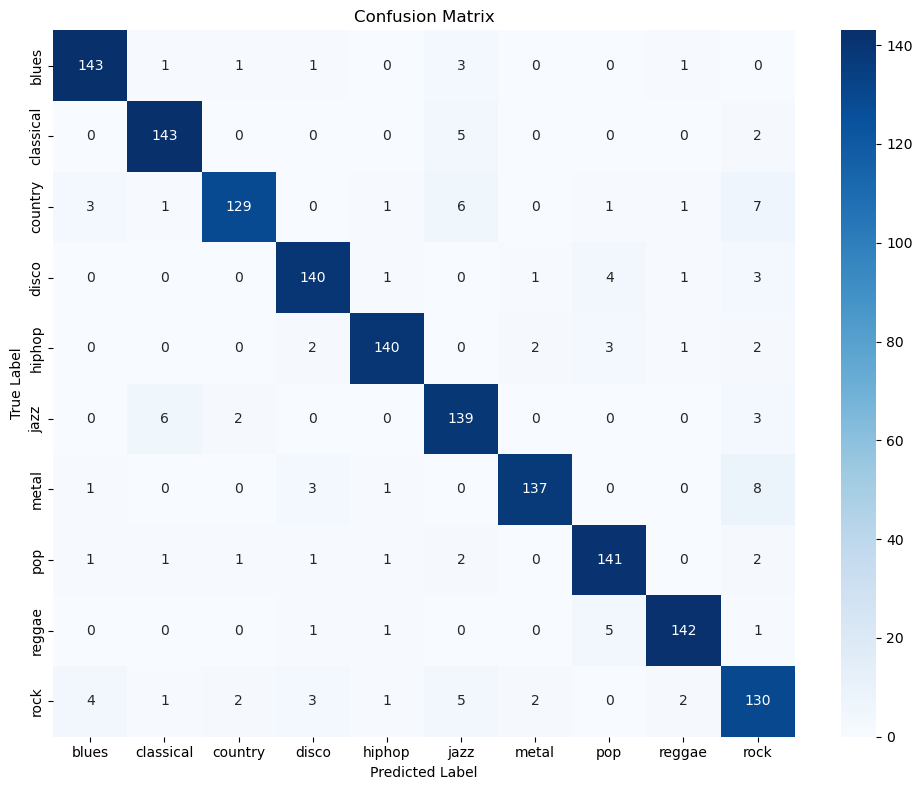

In [214]:
# Load label encoder used during preprocessing
import joblib
label_encoder = joblib.load(r"D:\Projects\music_genre_classification\music_genre_classification\data\Processed_data\label_encoder.pkl")
class_names = list(label_encoder.classes_)

# Or manually define if not saved
# class_names = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']

# Run final test evaluation
evaluate_model_results(model, test_loader, class_names, device)


In [215]:
save_path = r"D:\Projects\DL_gtzan\models\Baseline_MLP_Hyperparameter_tuning\genre_mlp_weights.pth"
torch.save(model.state_dict(), save_path)


In [216]:
import torch
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

def evaluate_metrics(model, dataloader, device, class_names):
    """
    Runs the model on dataloader, prints classification report,
    and returns the confusion matrix.
    
    model:         trained torch.nn.Module
    dataloader:    DataLoader for the split you want to evaluate
    device:        torch.device('cuda' or 'cpu')
    class_names:   list of label names in order
    """
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for X_batch, y_batch in dataloader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            preds = outputs.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())
    
    # Classification report
    report = classification_report(all_labels, all_preds, target_names=class_names)
    print("=== Classification Report ===\n", report)
    
    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    return cm

def plot_confusion_matrix(cm, class_names):
    """
    Plots a confusion matrix using Matplotlib.
    cm:           numpy array of shape (n_classes, n_classes)
    class_names:  list of label strings
    """
    plt.figure()
    plt.imshow(cm, interpolation='nearest')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.xticks(np.arange(len(class_names)), class_names, rotation=45)
    plt.yticks(np.arange(len(class_names)), class_names)
    plt.colorbar()
    plt.tight_layout()
    plt.show()

def plot_training_history(history):
    """
    history: dict with keys 'train_loss', 'val_loss', 'train_acc', 'val_acc'
             each mapping to a list of length num_epochs
    """
    epochs = range(1, len(history['train_loss']) + 1)

    # Loss curves
    plt.figure()
    plt.plot(epochs, history['train_loss'])
    plt.plot(epochs, history['val_loss'])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Val'])
    plt.title('Training vs. Validation Loss')
    plt.show()

    # Accuracy curves
    plt.figure()
    plt.plot(epochs, history['train_acc'])
    plt.plot(epochs, history['val_acc'])
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Val'])
    plt.title('Training vs. Validation Accuracy')
    plt.show()


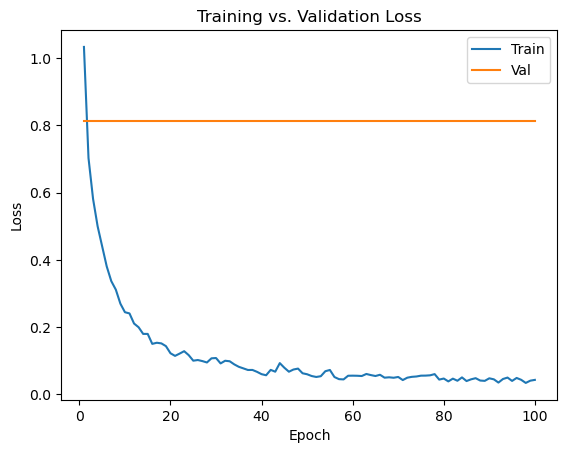

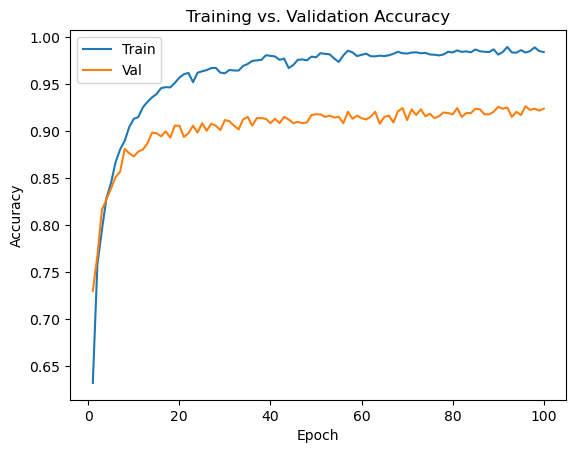

=== Classification Report ===
               precision    recall  f1-score   support

       blues       0.94      0.95      0.95       150
   classical       0.93      0.95      0.94       150
     country       0.96      0.87      0.91       149
       disco       0.93      0.93      0.93       150
      hiphop       0.96      0.93      0.95       150
        jazz       0.87      0.93      0.90       150
       metal       0.96      0.91      0.94       150
         pop       0.92      0.94      0.93       150
      reggae       0.96      0.95      0.95       150
        rock       0.82      0.87      0.84       150

    accuracy                           0.92      1499
   macro avg       0.92      0.92      0.92      1499
weighted avg       0.92      0.92      0.92      1499



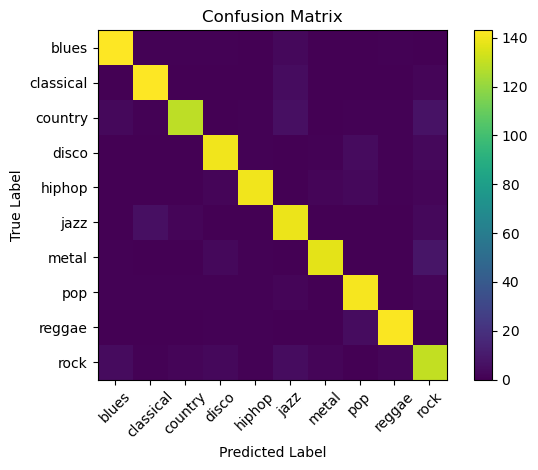

In [217]:
# 1) Plot loss & accuracy curves
plot_training_history(history)

# 2) Evaluate on test set & plot confusion matrix
cm = evaluate_metrics(model, test_loader, device, class_names)
plot_confusion_matrix(cm, class_names)
